In [ ]:
import os
import json
import pandas as pd
import numpy as np
from google.colab import drive
import cv2
from sklearn.preprocessing import LabelEncoder
from scipy import linalg
from google.colab.patches import cv2_imshow
from collections import Counter, defaultdict
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, Input, AveragePooling2D, Activation, BatchNormalization, Concatenate, SpatialDropout2D
from keras.utils import np_utils
from keras.optimizers import Adam, SGD
from keras.initializers import he_normal, random_normal
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.regularizers import l2
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [ ]:
train_target = pd.read_csv('fashion-small/fashion_small/styles.csv', error_bad_lines=False)

<ipython-input-5-51f475534dde>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  train_target = pd.read_csv('fashion-small/fashion_small/styles.csv', error_bad_lines=False)
Skipping line 6044: expected 10 fields, saw 11
Skipping line 6569: expected 10 fields, saw 11
Skipping line 7399: expected 10 fields, saw 11
Skipping line 7939: expected 10 fields, saw 11
Skipping line 9026: expected 10 fields, saw 11
Skipping line 10264: expected 10 fields, saw 11
Skipping line 10427: expected 10 fields, saw 11
Skipping line 10905: expected 10 fields, saw 11
Skipping line 11373: expected 10 fields, saw 11
Skipping line 11945: expected 10 fields, saw 11
Skipping line 14112: expected 10 fields, saw 11
Skipping line 14532: expected 10 fields, saw 11
Skipping line 15076: expected 10 fields, saw 12
Skipping line 29906: expected 10 fields, saw 11
Skipping line 31625: expected 10 fields, saw 11
Skipping line 3302

In [ ]:
l=[]
for i in train_target['id']:
    if not os.path.exists('fashion-small/fashion_small/fashion_small/resized_images/'+str(i) +".jpg"):
        l.append(i)
        train_target.drop(train_target[train_target.id == i].index, inplace=True)

In [ ]:
train_target = train_target.reset_index()
train_target = train_target.drop(['index'], axis=1)

In [ ]:
train_target.tail()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
44414,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe
44415,6461,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011.0,Casual,Lotto Men's Soccer Track Flip Flop
44416,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Puma Men Graphic Stellar Blue Tshirt
44417,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017.0,Casual,Rasasi Women Blue Lady Perfume
44418,51623,Women,Accessories,Watches,Watches,Pink,Winter,2016.0,Casual,Fossil Women Pink Dial Chronograph Watch ES3050


In [ ]:
matrix = np.zeros((train_target.shape[0], 64*64*3))

for i in range(0,train_target.shape[0]):
  try:
    # print(i)
    image = cv2.imread('fashion-small/fashion_small/fashion_small/resized_images/' + str(train_target['id'][i])+ '.jpg')
    resized_arr = cv2.resize(image, (64,64))
    img_arr = np.array(resized_arr)
    arr = img_arr.reshape(1,64*64*3)
    matrix[i] = arr
  except KeyError:
    print('Item not valid:',i)

In [ ]:
matrix.shape

(44419, 12288)

**Data - Images**

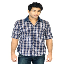

In [ ]:
sample_image_0 = matrix[0]
sample_image_0 = sample_image_0.reshape(64,64,3)
cv2_imshow(sample_image_0)

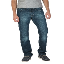

In [ ]:
sample_image_1 = matrix[1]
sample_image_1 = sample_image_1.reshape(64,64,3)
cv2_imshow(sample_image_1)

**Data - Labels**

In [ ]:
train_target.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


Text(0.5, 1.0, 'Histogram visualising the frequency of each class in the SubCategory feature')

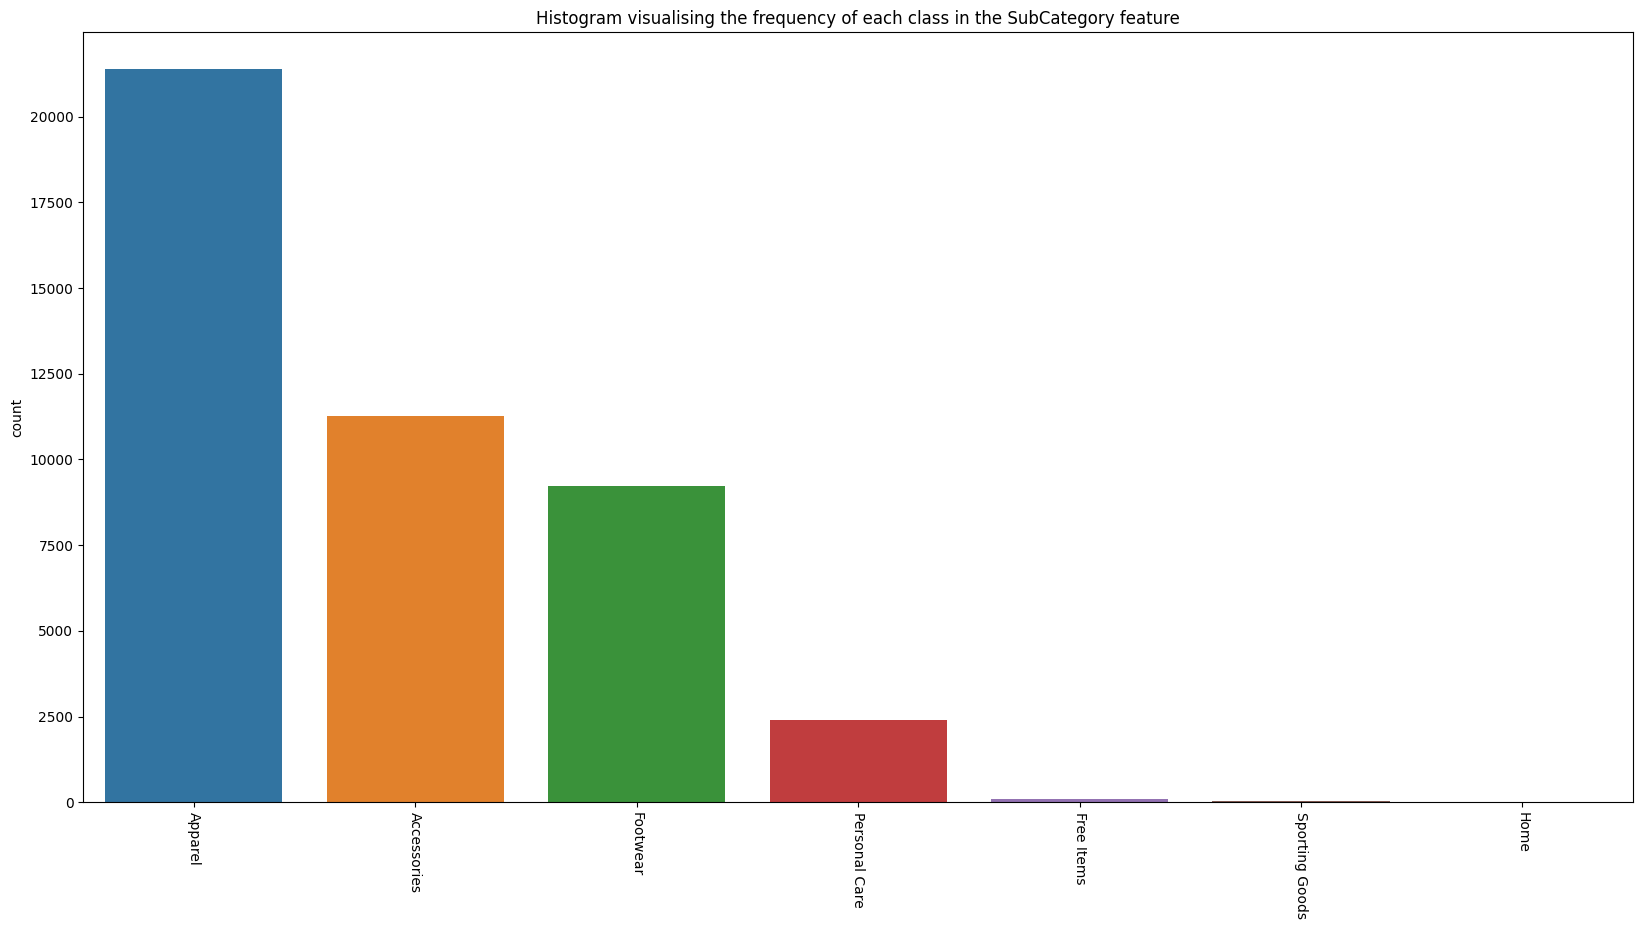

In [ ]:
counts = defaultdict(int)
for l in train_target['masterCategory']:
     counts[l] += 1

frequency = pd.DataFrame.from_dict(counts, orient='index')
frequency.columns = ['count']
frequency.sort_values('count', ascending=False, inplace=True)

fig, ax = plt.subplots()
ax = sns.barplot(x=frequency.index, y=frequency['count'], ax=ax)
fig.set_size_inches(20,10)
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=-90)
plt.title('Histogram visualising the frequency of each class in the MasterCategory feature')

Text(0.5, 1.0, 'Histogram visualising the frequency of each class in the SubCategory feature')

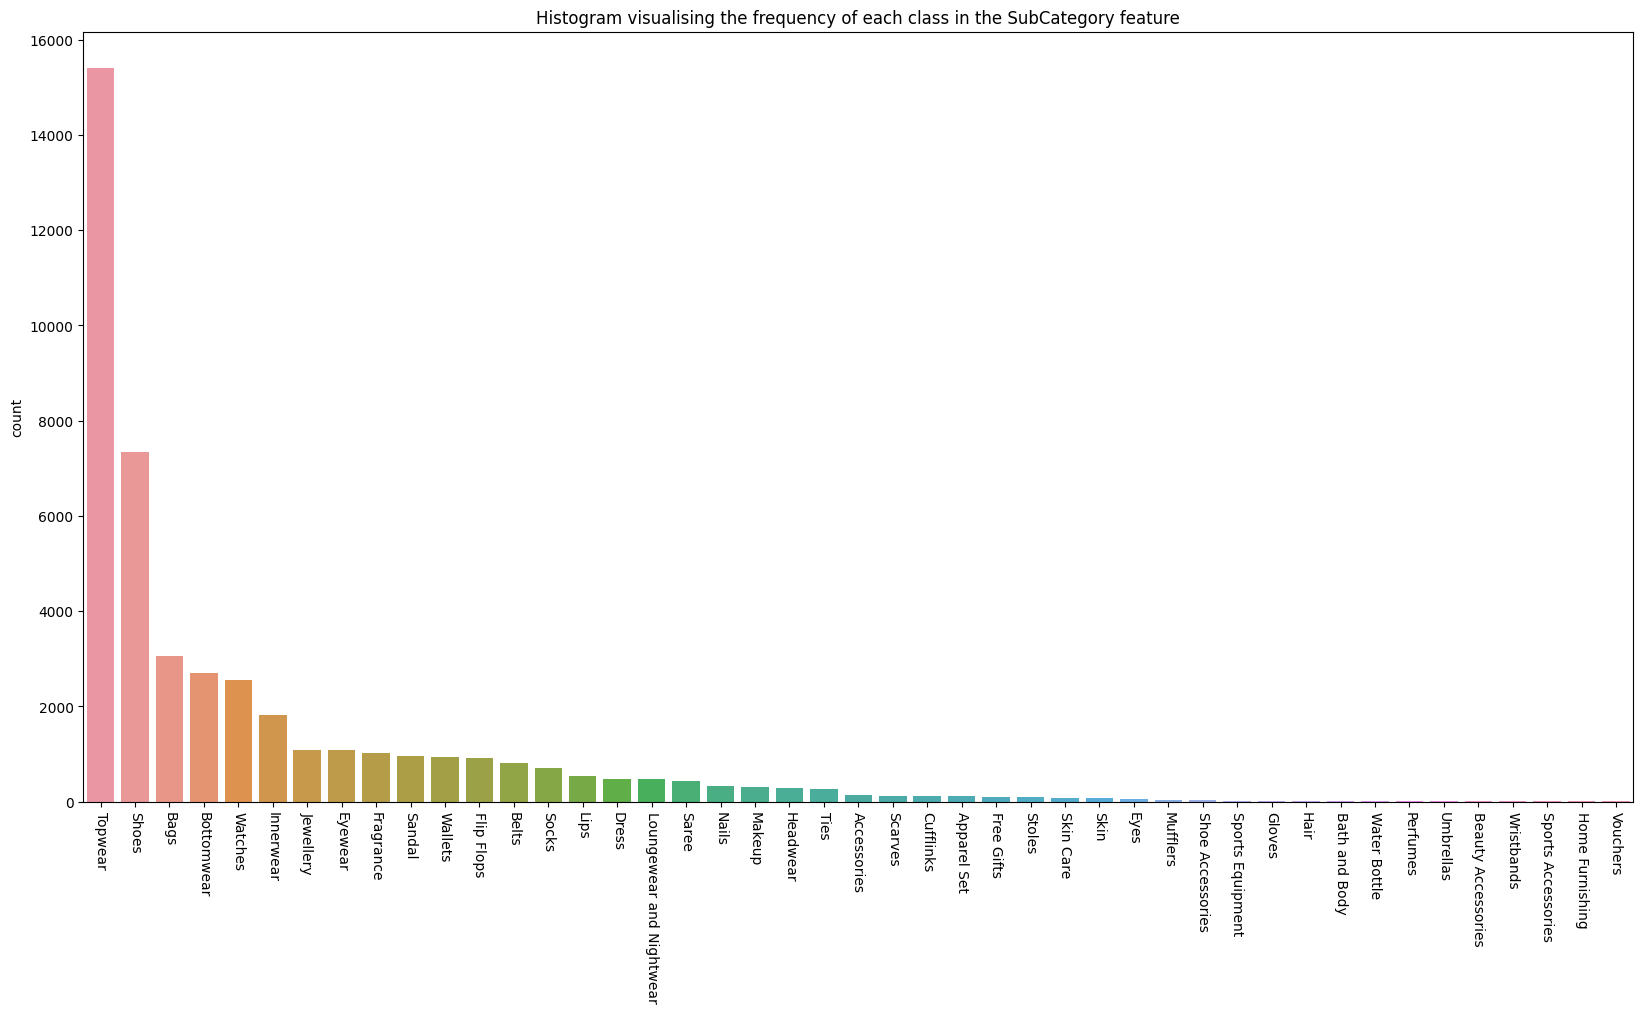

In [ ]:
counts = defaultdict(int)
for l in train_target['subCategory']:
     counts[l] += 1

frequency = pd.DataFrame.from_dict(counts, orient='index')
frequency.columns = ['count']
frequency.sort_values('count', ascending=False, inplace=True)

fig, ax = plt.subplots()
ax = sns.barplot(x=frequency.index, y=frequency['count'], ax=ax)
fig.set_size_inches(20,10)
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=-90)
plt.title('Histogram visualising the frequency of each class in the SubCategory feature')

Text(0.5, 1.0, 'Histogram visualising the frequency of each class in the SubCategory feature')

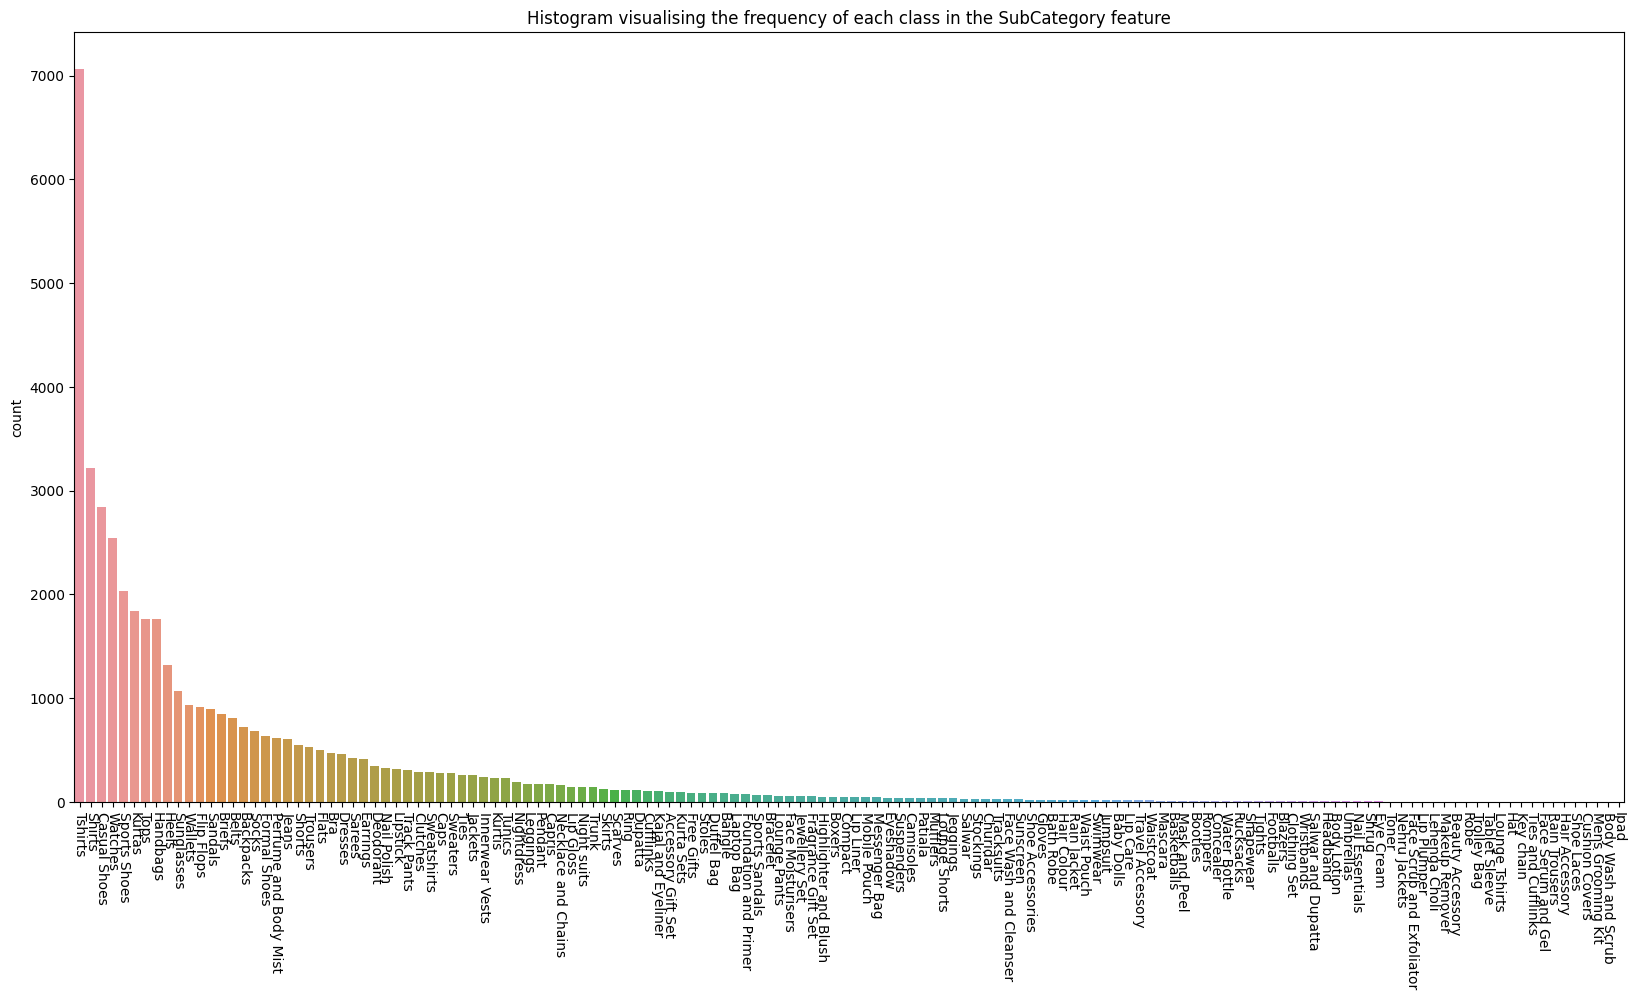

In [ ]:
counts = defaultdict(int)
for l in train_target['articleType']:
     counts[l] += 1

frequency = pd.DataFrame.from_dict(counts, orient='index')
frequency.columns = ['count']
frequency.sort_values('count', ascending=False, inplace=True)

fig, ax = plt.subplots()
ax = sns.barplot(x=frequency.index, y=frequency['count'], ax=ax)
fig.set_size_inches(20,10)
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=-90)
plt.title('Histogram visualising the frequency of each class in the SubCategory feature')

In [ ]:
#45 classes in the target variable
train_target.nunique()

id                    44419
gender                    5
masterCategory            7
subCategory              45
articleType             142
baseColour               46
season                    4
year                     13
usage                     8
productDisplayName    31116
dtype: int64

In [ ]:
data = pd.DataFrame(matrix)

In [ ]:
data.shape

(44419, 12288)

**Data Preprocessing**

**Data Reduction - Class Imbalance**

In [ ]:
#Write reasons
class_balance = train_target.groupby(['subCategory'], as_index = False)['id'].count()
class_balance = class_balance.rename(columns = {'id':'frequency'})

In [ ]:
categories = class_balance[class_balance['frequency']>1003]
categories

,subCategory,frequency
2,Bags,3055
6,Bottomwear,2693
10,Eyewear,1073
12,Fragrance,1011
18,Innerwear,1808
19,Jewellery,1079
30,Shoes,7343
38,Topwear,15398
42,Watches,2542


In [ ]:
filtered_target = train_target[train_target['subCategory'].isin(categories['subCategory'])]

In [ ]:
data = data.iloc[filtered_target.index,:].reset_index()
data = data.drop(['index'], axis=1)

In [ ]:
filtered_target = filtered_target.reset_index()
filtered_target = filtered_target.drop(['index'], axis=1)

In [ ]:
filtered_target.shape

(36002, 10)

In [ ]:
data.shape

(36002, 12288)

**Label Encoding**

In [ ]:
#Label encoding our target variable as we want it to be class
encoder = LabelEncoder()
filtered_target['subCategory'] = encoder.fit_transform(filtered_target['subCategory'])
n_classes = len(set(filtered_target['subCategory']))
filtered_target = np.asarray(filtered_target['subCategory'])

**PCA**

In [ ]:
class PCA():
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.variance=None

    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        X = X - self.mean
        covariance = np.cov(X, rowvar = False)
        self.eigen_values, self.eigen_vectors = linalg.eig(covariance)
        idx_order = np.argsort(self.eigen_values)[::-1]
        self.eigen_vectors_tranpose = self.eigen_vectors.transpose()

    def transform(self, X):
        X = X - self.mean
        self.eigen_values=self.eigen_values[:self.n_components]
        total_eigenvalues = sum(self.eigen_values)
        self.variance = [(i/total_eigenvalues)*100 for i in self.eigen_values]
        cum_sum_exp = np.cumsum(self.variance)
        return np.dot(X, self.eigen_vectors[:, :self.n_components])

    def inverse_transform(self, X):
        return np.dot(X, self.eigen_vectors_tranpose[:self.n_components]) + self.mean

In [ ]:
train_data = data
train_data = np.asarray(train_data)
train_data = train_data.reshape(data.shape[0], 64, 64,3)

reduced_images = np.zeros((train_data.shape[0], 64,64,3))

components=10
for i in range(train_data.shape[0]):

  blue_array,green_array,red_array=cv2.split(train_data[i])

  pca = PCA(components)
  pca.fit(blue_array)
  X_projected = pca.transform(blue_array)
  X_projected_inversed_blue = pca.inverse_transform(X_projected)
  cum_sum_exp_blue = np.cumsum(pca.variance)

  pca = PCA(components)
  pca.fit(green_array)
  X_projected = pca.transform(green_array)
  X_projected_inversed_green = pca.inverse_transform(X_projected)
  cum_sum_exp_green = np.cumsum(pca.variance)


  pca = PCA(components)
  pca.fit(red_array)
  X_projected = pca.transform(red_array)
  X_projected_inversed_red = pca.inverse_transform(X_projected)
  cum_sum_exp_red = np.cumsum(pca.variance)

  img_after_pca = np.dstack((X_projected_inversed_blue, X_projected_inversed_green, X_projected_inversed_red))
  reduced_images[i] = img_after_pca

<ipython-input-31-0e5c4276290a>:33: ComplexWarning: Casting complex values to real discards the imaginary part
  reduced_images[i] = img_after_pca
<ipython-input-30-1241e105209f>:18: RuntimeWarning: invalid value encountered in cdouble_scalars
  self.variance = [(i/total_eigenvalues)*100 for i in self.eigen_values]


In [ ]:
data_reduced = reduced_images
data_reduced.shape

(36002, 64, 64, 3)

In [ ]:
#Original data shape
data.shape

(36002, 12288)

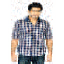

In [ ]:
cv2_imshow(data_reduced[0])

**Generating Train data and Test data**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_reduced, filtered_target, test_size=0.1, random_state=42)

**Model Development**

In [ ]:
y_actual = y_test

In [ ]:
y_train = keras.utils.to_categorical(y_train, n_classes)
y_test = keras.utils.to_categorical(y_test, n_classes)

**Basic CNN Model**

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(8, activation='sigmoid'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 12544)             0         
                                                                 
 dense_14 (Dense)            (None, 128)              

Epoch 1/10
1013/1013 [==============================] - 105s 103ms/step - loss: 3.7143 - accuracy: 0.9054
Epoch 2/10
1013/1013 [==============================] - 103s 101ms/step - loss: 0.1740 - accuracy: 0.9540
Epoch 3/10
1013/1013 [==============================] - 102s 101ms/step - loss: 0.1126 - accuracy: 0.9686
Epoch 4/10
1013/1013 [==============================] - 100s 99ms/step - loss: 0.4321 - accuracy: 0.8891
Epoch 5/10
1013/1013 [==============================] - 101s 100ms/step - loss: 0.1823 - accuracy: 0.9487
Epoch 6/10
1013/1013 [==============================] - 100s 99ms/step - loss: 0.1069 - accuracy: 0.9681
Epoch 7/10
1013/1013 [==============================] - 101s 100ms/step - loss: 0.0744 - accuracy: 0.9786
Epoch 8/10
1013/1013 [==============================] - 100s 99ms/step - loss: 0.0702 - accuracy: 0.9802
Epoch 9/10
1013/1013 [==============================] - 101s 100ms/step - loss: 0.0671 - accuracy: 0.9817
Epoch 10/10
1013/1013 [==========================

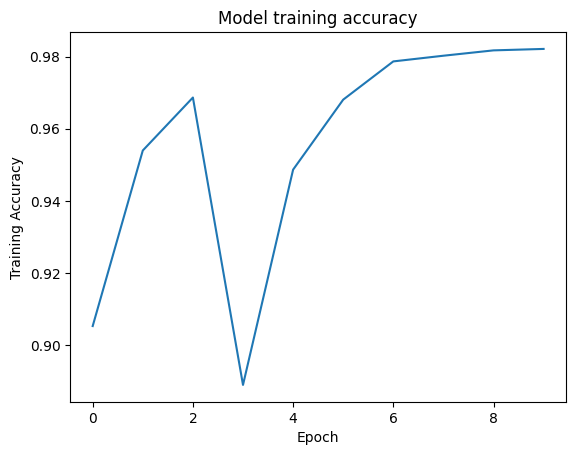

In [ ]:
cnn_model_data = model.fit(X_train, y_train,epochs=10)

plt.plot(cnn_model_data.history['accuracy'])
plt.title('Model training accuracy')
plt.ylabel('Training Accuracy')
plt.xlabel('Epoch')
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

113/113 [==============================] - 4s 32ms/step


In [ ]:
accuracy = accuracy_score(y_actual, y_pred_labels)
print(accuracy)

0.7642321577339628


**VGG Net**

In [ ]:
base_model = tf.keras.applications.vgg16.VGG16(include_top=False,weights='imagenet',input_tensor=None,input_shape=(64,64,3),pooling=None)
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
predictions = tf.keras.layers.Dense(n_classes, activation='softmax')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/10
1013/1013 [==============================] - 687s 677ms/step - loss: 0.5491 - accuracy: 0.9202
Epoch 2/10
1013/1013 [==============================] - 686s 677ms/step - loss: 0.1352 - accuracy: 0.9647
Epoch 3/10
1013/1013 [==============================] - 687s 678ms/step - loss: 0.0912 - accuracy: 0.9745
Epoch 4/10
1013/1013 [==============================] - 685s 676ms/step - loss: 0.0739 - accuracy: 0.9784
Epoch 5/10
1013/1013 [==============================] - 681s 673ms/step - loss: 0.0666 - accuracy: 0.9807
Epoch 6/10
1013/1013 [==============================] - 674s 666ms/step - loss: 0.0541 - accuracy: 0.9841
Epoch 7/10
1013/1013 [==============================] - 670s 661ms/step - loss: 0.0558 - accuracy: 0.9841
Epoch 8/10
1013/1013 [==============================] - 675s 667ms/step - loss: 0.0416 - accuracy: 0.9868
Epoch 9/10
1013/1013 [==============================] - 676s 667ms/step - loss: 0.0313 - accuracy: 0.9903
Epoch 10/10
1013/1013 [=======================

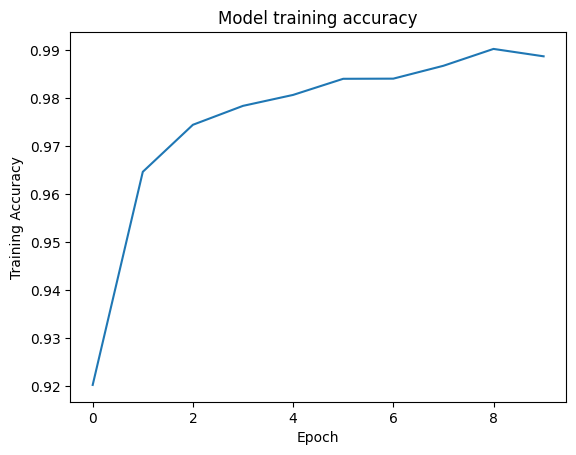

In [ ]:
vgg_model_data = model.fit(X_train, y_train,epochs=10, verbose = 1)

plt.plot(vgg_model_data.history['accuracy'])
plt.title('Model training accuracy')
plt.ylabel('Training Accuracy')
plt.xlabel('Epoch')
plt.show()

In [ ]:
model.save("vgg_model.h5")

In [ ]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

113/113 [==============================] - 82s 721ms/step


In [ ]:
accuracy = accuracy_score(y_actual, y_pred_labels)
print(accuracy)

0.959733407386837


**ResNet**

In [ ]:
base_model = tf.keras.applications.resnet50.ResNet50(include_top=False,weights='imagenet',input_tensor=None,input_shape=(64,64,3),pooling=None)
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
predictions = tf.keras.layers.Dense(n_classes, activation='softmax')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/10
1013/1013 [==============================] - 247s 240ms/step - loss: 0.2027 - accuracy: 0.9415
Epoch 2/10
1013/1013 [==============================] - 241s 238ms/step - loss: 0.0905 - accuracy: 0.9732
Epoch 3/10
1013/1013 [==============================] - 243s 240ms/step - loss: 0.0659 - accuracy: 0.9795
Epoch 4/10
1013/1013 [==============================] - 249s 246ms/step - loss: 0.0509 - accuracy: 0.9831
Epoch 5/10
1013/1013 [==============================] - 235s 232ms/step - loss: 0.0411 - accuracy: 0.9867
Epoch 6/10
1013/1013 [==============================] - 240s 237ms/step - loss: 0.0388 - accuracy: 0.9878
Epoch 7/10
1013/1013 [==============================] - 237s 234ms/step - loss: 0.0325 - accuracy: 0.9891
Epoch 8/10
1013/1013 [==============================] - 239s 236ms/step - loss: 0.0227 - accuracy: 0.9925
Epoch 9/10
1013/1013 [==============================] - 238s 235ms/step - loss: 0.0269 - accuracy: 0.9906
Epoch 10/10
1013/1013 [=======================

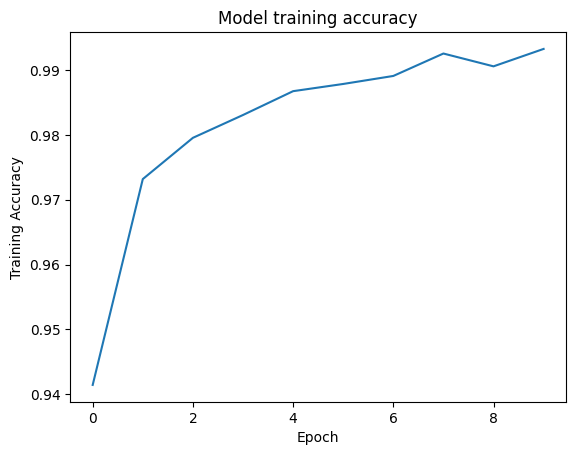

In [ ]:
model_data = model.fit(X_train, y_train,epochs=10, verbose = 1)

plt.plot(model_data.history['accuracy'])
plt.title('Model training accuracy')
plt.ylabel('Training Accuracy')
plt.xlabel('Epoch')
plt.show()

In [ ]:
model.save("Resnet_model.h5")

In [ ]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

113/113 [==============================] - 27s 228ms/step


In [ ]:
accuracy = accuracy_score(y_actual, y_pred_labels)
print(accuracy)

0.9719522354901416


**DenseNet**

In [ ]:
base_model = tf.keras.applications.densenet.DenseNet201(include_top=False, weights='imagenet', input_shape=(64, 64, 3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
predictions = tf.keras.layers.Dense(n_classes, activation='softmax')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

74836368/74836368 [==============================] - 3s 0us/step


Epoch 1/10
1013/1013 [==============================] - 355s 337ms/step - loss: 0.6842 - accuracy: 0.8483
Epoch 2/10
1013/1013 [==============================] - 342s 338ms/step - loss: 0.3018 - accuracy: 0.9122
Epoch 3/10
1013/1013 [==============================] - 341s 336ms/step - loss: 0.2473 - accuracy: 0.9258
Epoch 4/10
1013/1013 [==============================] - 342s 337ms/step - loss: 0.2237 - accuracy: 0.9313
Epoch 5/10
1013/1013 [==============================] - 334s 330ms/step - loss: 0.2010 - accuracy: 0.9392
Epoch 6/10
1013/1013 [==============================] - 337s 332ms/step - loss: 0.1835 - accuracy: 0.9446
Epoch 7/10
1013/1013 [==============================] - 338s 334ms/step - loss: 0.1804 - accuracy: 0.9436
Epoch 8/10
1013/1013 [==============================] - 338s 333ms/step - loss: 0.1692 - accuracy: 0.9487
Epoch 9/10
1013/1013 [==============================] - 336s 332ms/step - loss: 0.1517 - accuracy: 0.9507
Epoch 10/10
1013/1013 [=======================

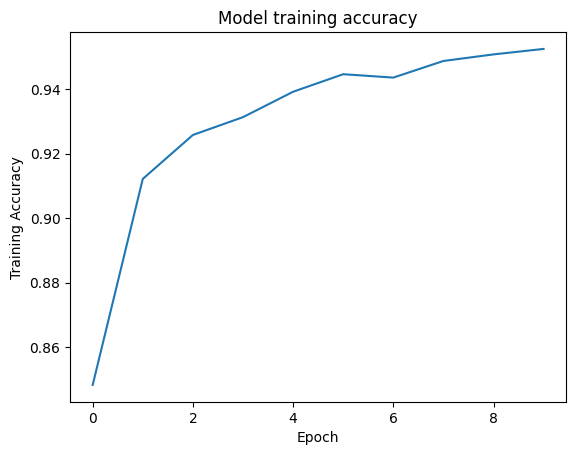

In [ ]:
densenet_model_data = model.fit(X_train, y_train,epochs=10, verbose = 1)

plt.plot(densenet_model_data.history['accuracy'])
plt.title('Model training accuracy')
plt.ylabel('Training Accuracy')
plt.xlabel('Epoch')
plt.show()

In [ ]:
model.save("Densenet_model.h5")

In [ ]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

113/113 [==============================] - 43s 380ms/step


In [ ]:
accuracy = accuracy_score(y_actual, y_pred_labels)
print(accuracy)

0.9316856428769786


**Observations and Results**

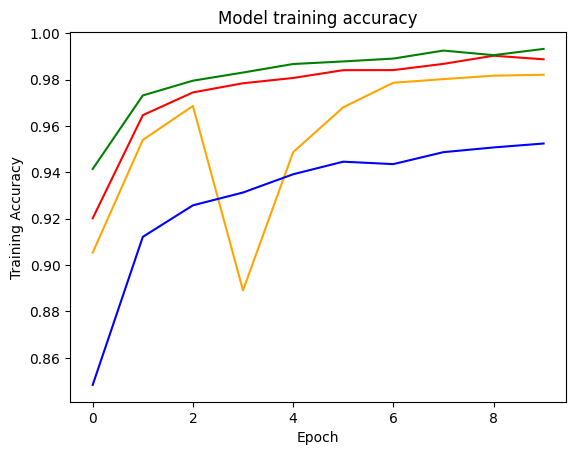

In [ ]:
plt.plot(cnn_model_data.history['accuracy'], color='orange')
plt.plot(vgg_model_data.history['accuracy'], color ='red')
plt.plot(densenet_model_data.history['accuracy'], color='blue')
plt.plot(model_data.history['accuracy'], color ='green')
plt.title('Model training accuracy')
plt.ylabel('Training Accuracy')
plt.xlabel('Epoch')
plt.show()

In [ ]:
test_accuracy = pd.DataFrame()
test_accuracy['CNN'] = [76.42]
test_accuracy['VGG'] = [95.97]
test_accuracy['DenseNet'] = [93.16]
test_accuracy['ResNet'] = [97.19]

In [ ]:
test_accuracy

,CNN,VGG,DenseNet,ResNet
0,76.42,95.97,93.16,97.19


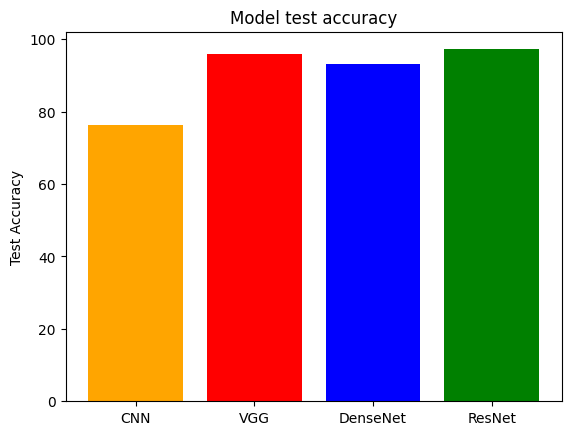

In [ ]:
plt.bar(x= 'CNN' , height = test_accuracy['CNN'], color='orange')
plt.bar(x= 'VGG' , height = test_accuracy['VGG'], color ='red')
plt.bar(x= 'DenseNet', height = test_accuracy['DenseNet'], color='blue')
plt.bar(x= 'ResNet', height =test_accuracy['ResNet'], color ='green')
plt.title('Model test accuracy')
plt.ylabel('Test Accuracy')
# plt.xlabel('')
plt.show()

**Comparison of the three architectures**

**Future Scope**

**Conclusion**

In [ ]:
df = pd.read_excel('training_time.xlsx')

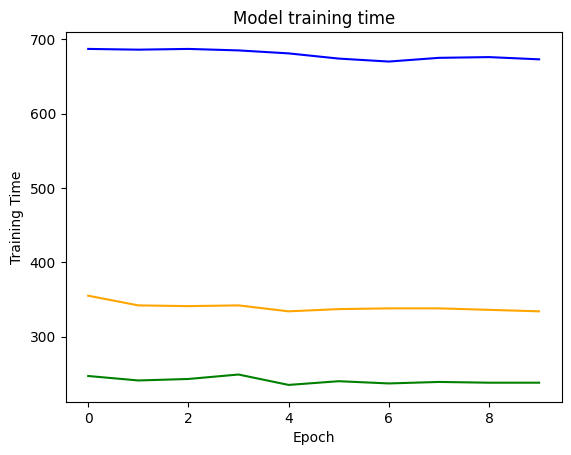

In [ ]:
plt.plot(df['ResNet'], color='green')
plt.plot(df['DenseNet'], color='orange')
plt.plot(df['VGG'], color='blue')
plt.title('Model training time')
plt.ylabel('Training Time')
plt.xlabel('Epoch')
plt.show()

References
[1] Shobhit Bhatnagar, Deepanway Ghosal, and Maheshkumar H Kolekar. “Classification of fashion article
images using convolutional neural networks”. In: 2017 Fourth International Conference on Image
Information Processing (ICIIP). IEEE. 2017, pp. 1–6.
[2] Han Xiao, Kashif Rasul, and Roland Vollgraf. “Fashion-mnist: a novel image dataset for benchmarking
machine learning algorithms”. In: arXiv preprint arXiv:1708.07747 (2017).
[3] Shivam S Kadam, Amol C Adamuthe, and Ashwini B Patil. “CNN model for image classification on
MNIST and fashion-MNIST dataset”. In: Journal of scientific research 64.2 (2020), pp. 374–384.
[4] Mohammed Kayed, Ahmed Anter, and Hadeer Mohamed. “Classification of garments from fashion
MNIST dataset using CNN LeNet-5 architecture”. In: 2020 international conference on innovative
trends in communication and computer engineering (ITCE). IEEE. 2020, pp. 238–243.
[5] VALDERI LEITHARDT. “Classifying garments from fashion-MNIST dataset through CNNs”. In: Advances
in Science, Technology and Engineering Systems Journal 6.1 (2021), pp. 989–994.
[6] Yaran Ji. “A novel CNN+ LSTM classification model based on fashion-MNIST”. In: International
Conference on Neural Networks, Information, and Communication Engineering (NNICE). Vol. 12258.
SPIE. 2022, pp. 178–184.

In [ ]:
# References
# [1] Shobhit Bhatnagar, Deepanway Ghosal, and Maheshkumar H Kolekar. “Classification of fashion article
# images using convolutional neural networks”. In: 2017 Fourth International Conference on Image
# Information Processing (ICIIP). IEEE. 2017, pp. 1–6.
# [2] Han Xiao, Kashif Rasul, and Roland Vollgraf. “Fashion-mnist: a novel image dataset for benchmarking
# machine learning algorithms”. In: arXiv preprint arXiv:1708.07747 (2017).
# [3] Shivam S Kadam, Amol C Adamuthe, and Ashwini B Patil. “CNN model for image classification on
# MNIST and fashion-MNIST dataset”. In: Journal of scientific research 64.2 (2020), pp. 374–384.
# [4] Mohammed Kayed, Ahmed Anter, and Hadeer Mohamed. “Classification of garments from fashion
# MNIST dataset using CNN LeNet-5 architecture”. In: 2020 international conference on innovative
# trends in communication and computer engineering (ITCE). IEEE. 2020, pp. 238–243.
# [5] VALDERI LEITHARDT. “Classifying garments from fashion-MNIST dataset through CNNs”. In: Advances
# in Science, Technology and Engineering Systems Journal 6.1 (2021), pp. 989–994.
# [6] Yaran Ji. “A novel CNN+ LSTM classification model based on fashion-MNIST”. In: International
# Conference on Neural Networks, Information, and Communication Engineering (NNICE). Vol. 12258.
# SPIE. 2022, pp. 178–184.